Connected to .venv (Python 3.10.7)

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

2024-11-07 20:39:43.221266: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 20:39:43.237435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 20:39:43.258283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 20:39:43.264562: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 20:39:43.281054: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 100

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(64, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(6, 6))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(128, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #4th layers
    c4 = keras.layers.Conv2D(512, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3, 
                                                  weight_decay=1e-5), 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-07 20:39:53.257432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22461 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-11-07 20:39:53.257990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 12268 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 25, 25,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 25, 25,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 25, 25,    │    204,928 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 25, 25,    │          0 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 128) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 256) │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 4, 256) │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 512) │  1,180,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 512) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 2, 2, 512) │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │  1,049,088 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]   

 Total params: 3,074,254 (11.73 MB)

 Trainable params: 3,072,334 (11.72 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


I0000 00:00:1731029999.720765   30599 service.cc:146] XLA service 0x7fc9780132c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731029999.720810   30599 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1731029999.720815   30599 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-07 20:39:59.886420: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-07 20:40:00.377701: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-07 20:40:03.436983: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-11-07 20:40:05.151906: I externa

  8/225 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - dense_1_accuracy: 0.0826 - dense_1_loss: 3.3858 - dense_5_loss: 0.5245 - dense_5_mae: 0.8891 - loss: 3.9103   

I0000 00:00:1731030013.254130   30599 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - dense_1_accuracy: 0.0835 - dense_1_loss: 2.5951 - dense_5_loss: 0.4032 - dense_5_mae: 0.7745 - loss: 2.9982

2024-11-07 20:40:25.425318: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_341', 8 bytes spill stores, 8 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 67ms/step - dense_1_accuracy: 0.0834 - dense_1_loss: 2.5943 - dense_5_loss: 0.4025 - dense_5_mae: 0.7739 - loss: 2.9968 - val_dense_1_accuracy: 0.0933 - val_dense_1_loss: 2.5113 - val_dense_5_loss: 0.2586 - val_dense_5_mae: 0.6436 - val_loss: 2.7722 - learning_rate: 0.0010
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - dense_1_accuracy: 0.0797 - dense_1_loss: 2.4852 - dense_5_loss: 0.2504 - dense_5_mae: 0.6375 - loss: 2.7357 - val_dense_1_accuracy: 0.0844 - val_dense_1_loss: 2.4852 - val_dense_5_loss: 0.2509 - val_dense_5_mae: 0.6376 - val_loss: 2.7361 - learning_rate: 0.0010
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - dense_1_accuracy: 0.0776 - dense_1_loss: 2.4850 - dense_5_loss: 0.2501 - dense_5_mae: 0.6361 - loss: 2.7351 - val_dense_1_accuracy: 0.0833 - val_dense_1_loss: 2.4850 - val_dense_5_loss: 0.2500 - val_dense_5_mae: 0.6363 - val_loss: 2.7350 - learning_rate: 0.0010
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - d

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 100

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(64, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(6, 6))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(128, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #4th layers
    c4 = keras.layers.Conv2D(512, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 150, 150,  │      3,200 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 25, 25,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        256 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 25, 25,    │    204,928 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 25, 25,    │          0 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 128) │          0 │ dropout_7[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 8, 8, 256) │          0 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 4, 4, 256) │          0 │ dropout_8[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 4, 4, 512) │  1,180,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 4, 4, 512) │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 2, 2, 512) │          0 │ dropout_9[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │  1,049,088 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 512)       │          0 │ dense_8[0][0]   

 Total params: 3,074,254 (11.73 MB)

 Trainable params: 3,072,334 (11.72 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping]
)

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - dense_11_loss: 0.4003 - dense_11_mae: 0.7680 - dense_7_accuracy: 0.0800 - dense_7_loss: 2.6026 - loss: 3.0028 - val_dense_11_loss: 0.2505 - val_dense_11_mae: 0.6376 - val_dense_7_accuracy: 0.0817 - val_dense_7_loss: 2.4870 - val_loss: 2.7373
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - dense_11_loss: 0.2516 - dense_11_mae: 0.6381 - dense_7_accuracy: 0.0828 - dense_7_loss: 2.4850 - loss: 2.7366 - val_dense_11_loss: 0.2499 - val_dense_11_mae: 0.6362 - val_dense_7_accuracy: 0.0856 - val_dense_7_loss: 2.4850 - val_loss: 2.7349
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - dense_11_loss: 0.2501 - dense_11_mae: 0.6366 - dense_7_accuracy: 0.0831 - dense_7_loss: 2.4849 - loss: 2.7350 - val_dense_11_loss: 0.2499 - val_dense_11_mae: 0.6361 - val_dense_7_accuracy: 0.0828 - val_dense_7_loss: 2.4851 - val_loss: 2.7349
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - dense_11_loss: 0.2501 - dense_11_mae: 0.6366 - de

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=44) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 100

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(64, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(12, 12))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(128, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(6, 6))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #4th layers
    c4 = keras.layers.Conv2D(512, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 150, 150,  │      3,200 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 12, 12,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        256 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 12, 12,    │    204,928 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 12, 12,    │          0 │ conv2d_9[0][0]    │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 2, 2, 128) │          0 │ dropout_14[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ max_pooling2d_9[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 2, 2, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 2, 2, 256) │          0 │ conv2d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 1, 1, 256) │          0 │ dropout_15[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 256) │      1,024 │ max_pooling2d_10… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 1, 1, 512) │  1,180,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 1, 1, 512) │          0 │ conv2d_11[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 0, 0, 512) │          0 │ dropout_16[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 0, 0, 512) │      2,048 │ max_pooling2d_11… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 0)         │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 512)       │        512 │ flatten_2[0][0] 

 Total params: 1,763,534 (6.73 MB)

 Trainable params: 1,761,614 (6.72 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping]
)

Epoch 1/100


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node functional_2_1/max_pooling2d_11_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](functional_2_1/dropout_16_1/stateless_dropout/SelectV2)' with input shapes: [64,1,1,512].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(64, 1, 1, 512), dtype=float32)

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=45) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 100

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(6, 6))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 150, 150,  │      1,600 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 25, 25,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        128 │ max_pooling2d_12… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 25, 25,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 25, 25,    │          0 │ conv2d_13[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 64)  │          0 │ dropout_21[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ max_pooling2d_13… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 8, 8, 128) │          0 │ conv2d_14[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 4, 4, 128) │          0 │ dropout_22[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ max_pooling2d_14… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 4, 4, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 4, 4, 256) │          0 │ conv2d_15[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 2, 2, 256) │          0 │ dropout_23[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 256) │      1,024 │ max_pooling2d_15… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 512)       │    524,800 │ flatten_3[0][0] 

 Total params: 1,155,406 (4.41 MB)

 Trainable params: 1,154,446 (4.40 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping]
)

Epoch 1/100


2024-11-07 21:00:44.524290: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-11-07 21:00:45.902953: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 16 bytes spill stores, 16 bytes spill loads

2024-11-07 21:00:46.571482: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 32 bytes spill stores, 32 bytes spill loads

2024-11-07 21:00:46.705345: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 12 bytes spill stores, 12 bytes spill loads

2024-11-07 21:00:46.714489: I external/local_xla/xla/stream_executor/cuda/cuda

225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - dense_19_accuracy: 0.1031 - dense_19_loss: 2.5698 - dense_23_loss: 0.3192 - dense_23_mae: 0.6915 - loss: 2.8891 - val_dense_19_accuracy: 0.0900 - val_dense_19_loss: 2.5929 - val_dense_23_loss: 0.2758 - val_dense_23_mae: 0.6577 - val_loss: 2.8662
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - dense_19_accuracy: 0.2003 - dense_19_loss: 2.1248 - dense_23_loss: 0.2160 - dense_23_mae: 0.5636 - loss: 2.3408 - val_dense_19_accuracy: 0.1022 - val_dense_19_loss: 2.6124 - val_dense_23_loss: 0.2556 - val_dense_23_mae: 0.6392 - val_loss: 2.8745
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - dense_19_accuracy: 0.4843 - dense_19_loss: 1.2504 - dense_23_loss: 0.1890 - dense_23_mae: 0.5156 - loss: 1.4393 - val_dense_19_accuracy: 0.3789 - val_dense_19_loss: 1.7298 - val_dense_23_loss: 0.2565 - val_dense_23_mae: 0.6201 - val_loss: 1.9732
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - dense_19_accuracy: 0.7120 - dense_19_loss: 0.7146

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

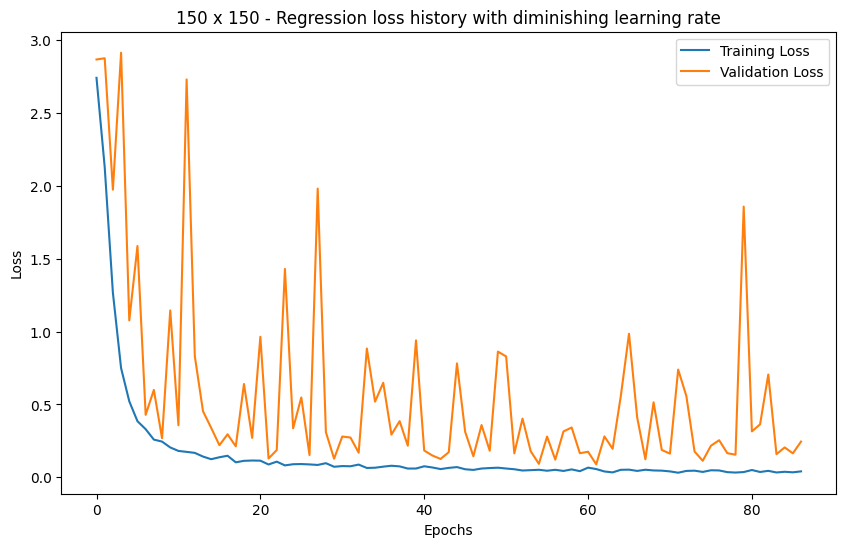

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

2024-11-07 21:06:59.473295: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 12 bytes spill stores, 12 bytes spill loads

2024-11-07 21:06:59.635949: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 32 bytes spill stores, 32 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours_real = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours_real)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

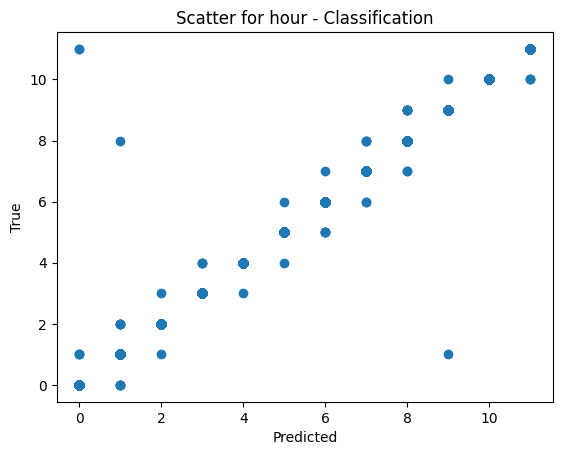

In [ ]:
# Scatter plot to show deviation for hour from Real to Pred

plt.scatter(y_pred_hours, y_test_hours_real)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes_real =  y_test[:,1]

# Convert the sin and cos values back to minutes
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)

abs_mins = abs(y_pred_mins - y_test_minutes_real)
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

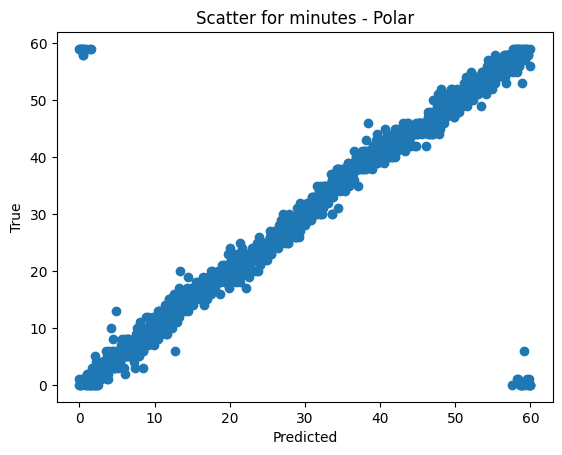

In [ ]:
# Scatter plot to show deviation for minutes from Real to Pred
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

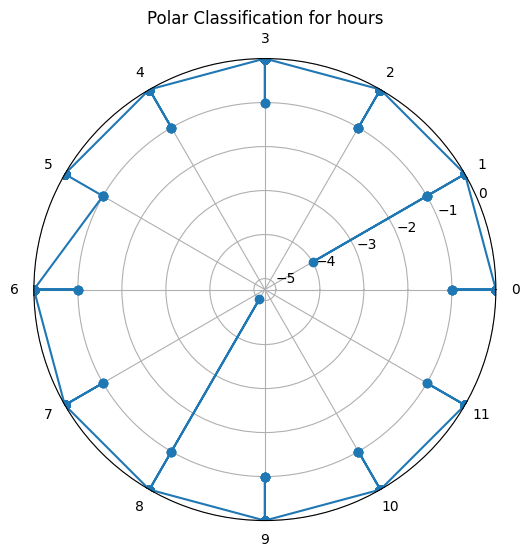

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours_real)
sorted_y_test_hr = y_test_hours_real[sorted_indices_hr]

# Create polar plot to show common sense error for hour from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Polar Classification for hours")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

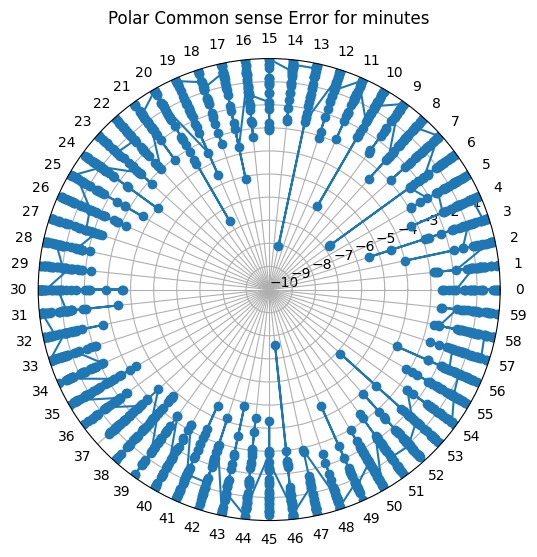

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes_real)
sorted_y_test_min = y_test_minutes_real[sorted_indices_min]

# Create polar plot to show common sense error for minutes from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Polar Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
score = model.evaluate(x_test_reshaped, [y_test_hours, y_test_minutes], verbose=False) 

In [ ]:
for each in history.history.keys():
    print(f"Train {each}: {history.history[each][-1]}")

print(f"\nTest dense_19_accuracy: {score[3]}")
print(f"Test dense_19_loss: {score[0]}")
print(f"Test dense_23_loss: {score[1]}")
print(f"Test dense_23_mae: {score[2]}")
print(f"Test loss: {score[4]}\n")

print(f"Common Sense MAE Min Test: {np.mean(cse_min/60)}")

Train dense_19_accuracy: 0.9890972375869751
Train dense_19_loss: 0.03090325929224491
Train dense_23_loss: 0.010107148438692093
Train dense_23_mae: 0.10159952193498611
Train loss: 0.041010428220033646
Train val_dense_19_accuracy: 0.9405555725097656
Train val_dense_19_loss: 0.22717106342315674
Train val_dense_23_loss: 0.015486971475183964
Train val_dense_23_mae: 0.11011037975549698
Train val_loss: 0.24540695548057556

Test dense_19_accuracy: 0.9755555391311646
Test dense_19_loss: 0.09981507807970047
Test dense_23_loss: 0.09205900877714157
Test dense_23_mae: 0.006634584628045559
Test loss: 0.08357050269842148

Common Sense MAE Min Test: 0.01919658262614609


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=45) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 100

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(6, 6))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 150, 150,  │      1,600 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 25, 25,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        128 │ max_pooling2d_16… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 25, 25,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 25, 25,    │          0 │ conv2d_17[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 8, 8, 64)  │          0 │ dropout_28[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ max_pooling2d_17… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 8, 8, 128) │          0 │ conv2d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 4, 4, 128) │          0 │ dropout_29[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ max_pooling2d_18… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 4, 4, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 4, 4, 256) │          0 │ conv2d_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 2, 2, 256) │          0 │ dropout_30[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 256) │      1,024 │ max_pooling2d_19… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 512)       │    524,800 │ flatten_4[0][0] 

 Total params: 1,155,406 (4.41 MB)

 Trainable params: 1,154,446 (4.40 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - dense_25_accuracy: 0.0864 - dense_25_loss: 2.5746 - dense_29_loss: 0.3375 - dense_29_mae: 0.7106 - loss: 2.9121 - val_dense_25_accuracy: 0.0956 - val_dense_25_loss: 2.5256 - val_dense_29_loss: 0.2504 - val_dense_29_mae: 0.6363 - val_loss: 2.7784 - learning_rate: 0.0010
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - dense_25_accuracy: 0.1458 - dense_25_loss: 2.3187 - dense_29_loss: 0.2375 - dense_29_mae: 0.6055 - loss: 2.5562 - val_dense_25_accuracy: 0.0961 - val_dense_25_loss: 2.4890 - val_dense_29_loss: 0.2508 - val_dense_29_mae: 0.6360 - val_loss: 2.7383 - learning_rate: 0.0010
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - dense_25_accuracy: 0.3915 - dense_25_loss: 1.4562 - dense_29_loss: 0.2096 - dense_29_mae: 0.5521 - loss: 1.6659 - val_dense_25_accuracy: 0.4072 - val_dense_25_loss: 1.3558 - val_dense_29_loss: 0.2204 - val_dense_29_mae: 0.5842 - val_loss: 1.5766 - learning_rate: 0.0010
Epoch 4/100
225/225 ━

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

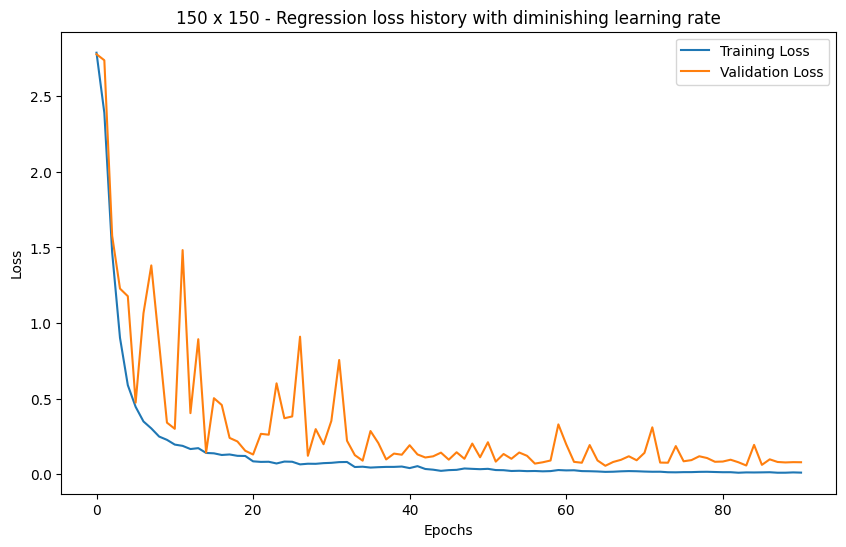

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours_real = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours_real)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

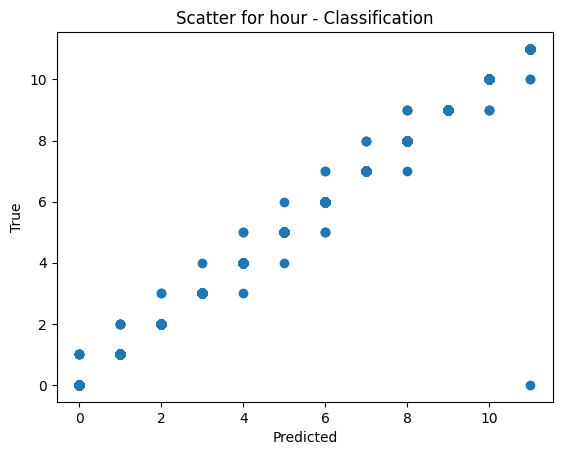

In [ ]:
# Scatter plot to show deviation for hour from Real to Pred

plt.scatter(y_pred_hours, y_test_hours_real)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes_real =  y_test[:,1]

# Convert the sin and cos values back to minutes
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)

abs_mins = abs(y_pred_mins - y_test_minutes_real)
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

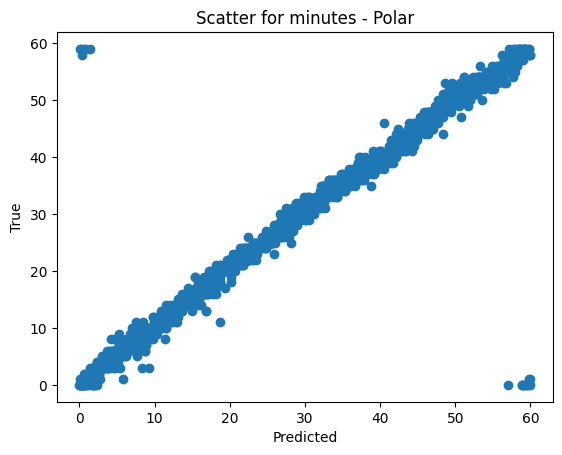

In [ ]:
# Scatter plot to show deviation for minutes from Real to Pred
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

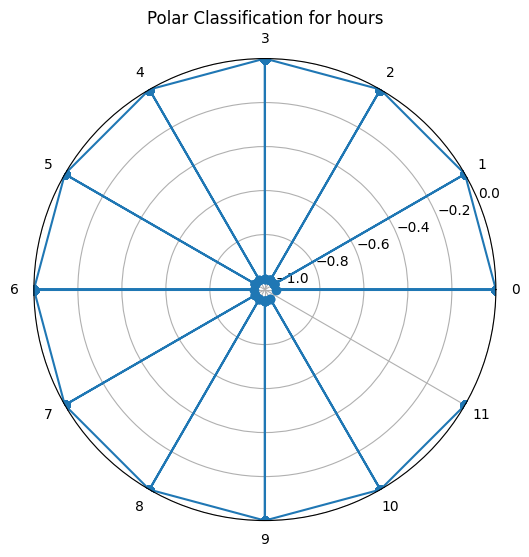

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours_real)
sorted_y_test_hr = y_test_hours_real[sorted_indices_hr]

# Create polar plot to show common sense error for hour from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Polar Classification for hours")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

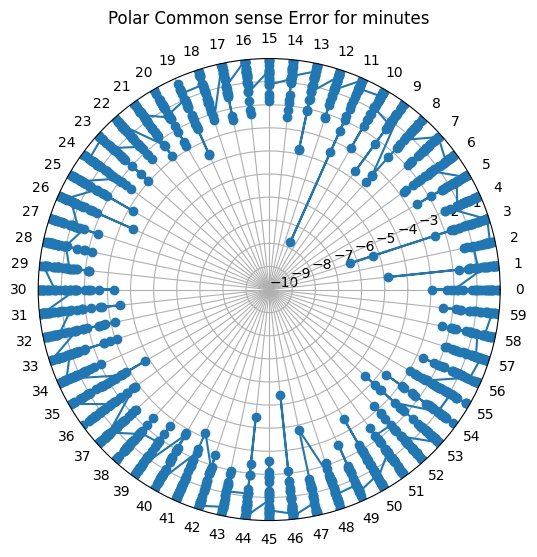

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes_real)
sorted_y_test_min = y_test_minutes_real[sorted_indices_min]

# Create polar plot to show common sense error for minutes from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Polar Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
score = model.evaluate(x_test_reshaped, [y_test_hours, y_test_minutes], verbose=False) 

In [ ]:
for each in history.history.keys():
    print(f"Train {each}: {history.history[each][-1]}")

print(f"\nTest dense_19_accuracy: {score[3]}")
print(f"Test dense_19_loss: {score[0]}")
print(f"Test dense_23_loss: {score[1]}")
print(f"Test dense_23_mae: {score[2]}")
print(f"Test loss: {score[4]}\n")

print(f"Common Sense MAE Min Test: {np.mean(cse_min/60)}")

Train dense_25_accuracy: 0.9987499713897705
Train dense_25_loss: 0.003845860715955496
Train dense_29_loss: 0.005988012067973614
Train dense_29_mae: 0.07981684058904648
Train loss: 0.009833873249590397
Train val_dense_25_accuracy: 0.9838888645172119
Train val_dense_25_loss: 0.07203003764152527
Train val_dense_29_loss: 0.004365147091448307
Train val_dense_29_mae: 0.06992798298597336
Train val_loss: 0.07846307754516602
Train learning_rate: 0.00016777217388153076

Test dense_19_accuracy: 0.9794444441795349
Test dense_19_loss: 0.08616919070482254
Test dense_23_loss: 0.07872982323169708
Test dense_23_mae: 0.006413743831217289
Test loss: 0.08778800070285797

Common Sense MAE Min Test: 0.01585524657042697


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images.npy")
labels = np.load("A1/data/labels.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=45) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 100

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(6, 6))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 75, 75,    │      1,600 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 12, 12,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        128 │ max_pooling2d_20… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 12, 12,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 12, 12,    │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 4, 4, 64)  │          0 │ dropout_35[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ max_pooling2d_21… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 4, 4, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 4, 4, 128) │          0 │ conv2d_22[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 2, 2, 128) │          0 │ dropout_36[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ max_pooling2d_22… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 2, 2, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 2, 2, 256) │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 1, 1, 256) │          0 │ dropout_37[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 256) │      1,024 │ max_pooling2d_23… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 512)       │    131,584 │ flatten_5[0][0] 

 Total params: 663,886 (2.53 MB)

 Trainable params: 662,926 (2.53 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


2024-11-07 21:15:32.396448: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - dense_31_accuracy: 0.1086 - dense_31_loss: 2.7032 - dense_35_loss: 0.2931 - dense_35_mae: 0.6690 - loss: 2.9963 - val_dense_31_accuracy: 0.0956 - val_dense_31_loss: 2.7202 - val_dense_35_loss: 0.3086 - val_dense_35_mae: 0.6869 - val_loss: 3.0279 - learning_rate: 0.0010
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - dense_31_accuracy: 0.2698 - dense_31_loss: 1.8841 - dense_35_loss: 0.1965 - dense_35_mae: 0.5269 - loss: 2.0806 - val_dense_31_accuracy: 0.0983 - val_dense_31_loss: 2.8431 - val_dense_35_loss: 0.2469 - val_dense_35_mae: 0.6308 - val_loss: 3.0928 - learning_rate: 0.0010
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - dense_31_accuracy: 0.4973 - dense_31_loss: 1.2190 - dense_35_loss: 0.2035 - dense_35_mae: 0.5484 - loss: 1.4225 - val_dense_31_accuracy: 0.4606 - val_dense_31_loss: 1.2849 - val_dense_35_loss: 0.1703 - val_dense_35_mae: 0.5043 - val_loss: 1.4481 - learning_rate: 0.0010
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

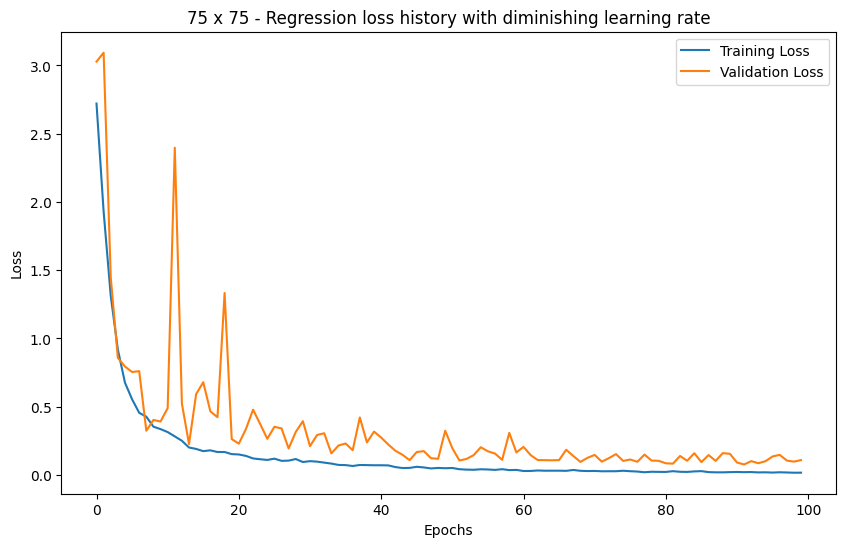

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours_real = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours_real)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

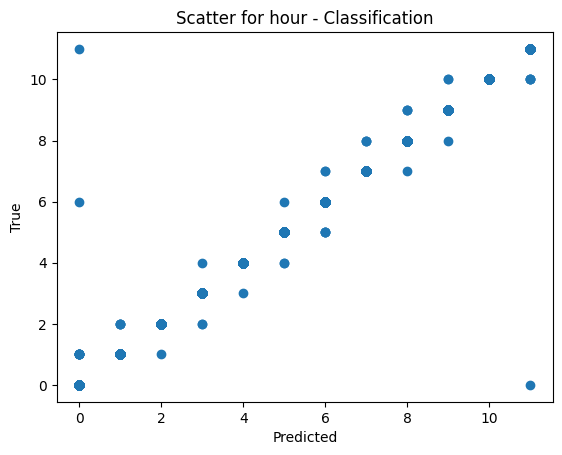

In [ ]:
# Scatter plot to show deviation for hour from Real to Pred

plt.scatter(y_pred_hours, y_test_hours_real)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes_real =  y_test[:,1]

# Convert the sin and cos values back to minutes
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)

abs_mins = abs(y_pred_mins - y_test_minutes_real)
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

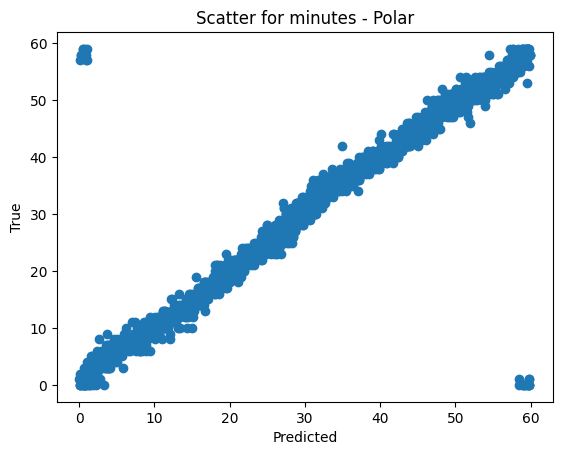

In [ ]:
# Scatter plot to show deviation for minutes from Real to Pred
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

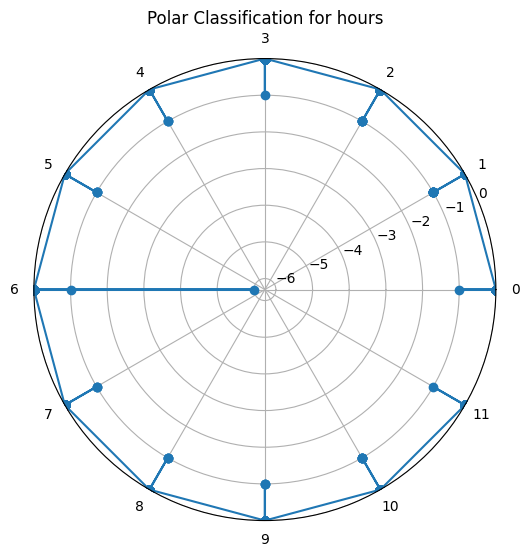

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours_real)
sorted_y_test_hr = y_test_hours_real[sorted_indices_hr]

# Create polar plot to show common sense error for hour from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Polar Classification for hours")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

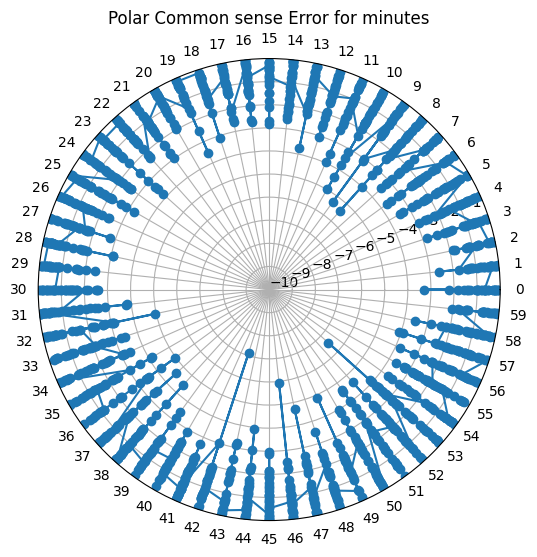

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes_real)
sorted_y_test_min = y_test_minutes_real[sorted_indices_min]

# Create polar plot to show common sense error for minutes from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Polar Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
score = model.evaluate(x_test_reshaped, [y_test_hours, y_test_minutes], verbose=False) 

In [ ]:
for each in history.history.keys():
    print(f"Train {each}: {history.history[each][-1]}")

print(f"\nTest dense_19_accuracy: {score[3]}")
print(f"Test dense_19_loss: {score[0]}")
print(f"Test dense_23_loss: {score[1]}")
print(f"Test dense_23_mae: {score[2]}")
print(f"Test loss: {score[4]}\n")

print(f"Common Sense MAE Min Test: {np.mean(cse_min/60)}")

Train dense_31_accuracy: 0.997083306312561
Train dense_31_loss: 0.00829760730266571
Train dense_35_loss: 0.009132505394518375
Train dense_35_mae: 0.09732706844806671
Train loss: 0.017430108040571213
Train val_dense_31_accuracy: 0.9733333587646484
Train val_dense_31_loss: 0.09758719801902771
Train val_dense_35_loss: 0.008884739130735397
Train val_dense_35_mae: 0.08861234039068222
Train val_loss: 0.10962124913930893
Train learning_rate: 0.00013421774201560766

Test dense_19_accuracy: 0.9755555391311646
Test dense_19_loss: 0.10086312890052795
Test dense_23_loss: 0.09184969216585159
Test dense_23_mae: 0.007855779491364956
Test loss: 0.09209846705198288

Common Sense MAE Min Test: 0.02095315989727775


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=45) 
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

# y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
# y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 100

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    # x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    # x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(7, 7),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(6, 6))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 150, 150,  │      1,600 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 25, 25,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        128 │ max_pooling2d_24… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 25, 25,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 25, 25,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 8, 8, 64)  │          0 │ dropout_42[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ max_pooling2d_25… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 8, 8, 128) │          0 │ conv2d_26[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 4, 4, 128) │          0 │ dropout_43[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ max_pooling2d_26… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 4, 4, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 4, 4, 256) │          0 │ conv2d_27[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 2, 2, 256) │          0 │ dropout_44[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 256) │      1,024 │ max_pooling2d_27… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 512)       │    524,800 │ flatten_6[0][0] 

 Total params: 1,155,406 (4.41 MB)

 Trainable params: 1,154,446 (4.40 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                # validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - dense_37_accuracy: 0.0848 - dense_37_loss: 2.5731 - dense_41_loss: 0.3258 - dense_41_mae: 0.6991 - loss: 2.8989 - learning_rate: 0.0010
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - dense_37_accuracy: 0.0814 - dense_37_loss: 2.4850 - dense_41_loss: 0.2531 - dense_41_mae: 0.6385 - loss: 2.7381 - learning_rate: 0.0010
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - dense_37_accuracy: 0.0865 - dense_37_loss: 2.4850 - dense_41_loss: 0.2503 - dense_41_mae: 0.6372 - loss: 2.7352 - learning_rate: 0.0010
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - dense_37_accuracy: 0.0782 - dense_37_loss: 2.4852 - dense_41_loss: 0.2501 - dense_41_mae: 0.6375 - loss: 2.7353 - learning_rate: 0.0010
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - dense_37_accuracy: 0.0841 - dense_37_loss: 2.4851 - dense_41_loss: 0.2500 - dense_41_mae: 0.6355 - loss: 2.7351 - learning_rate: 0.0010
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━

In [ ]:
loss = history.history['loss']
# val_loss = history.history['val_loss']

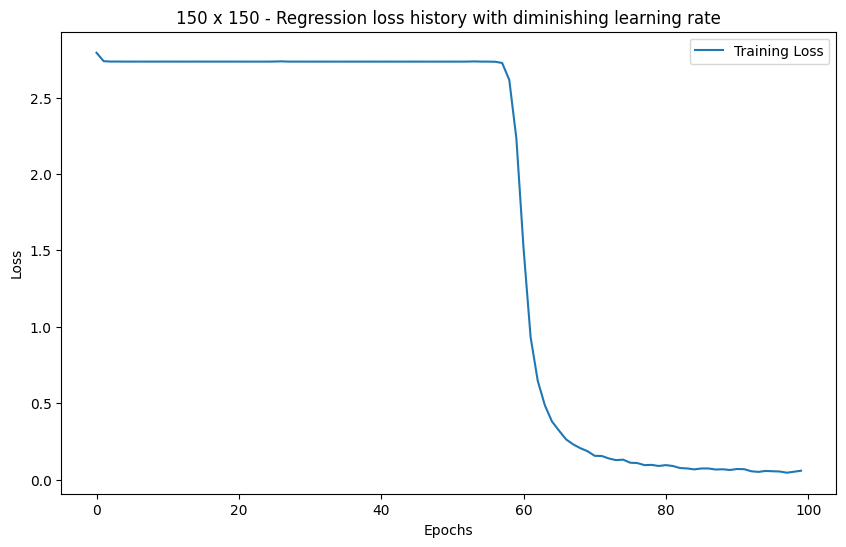

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

 99/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2024-11-07 21:26:51.222175: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads

2024-11-07 21:26:51.948272: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 12 bytes spill stores, 12 bytes spill loads



113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours_real = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours_real)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

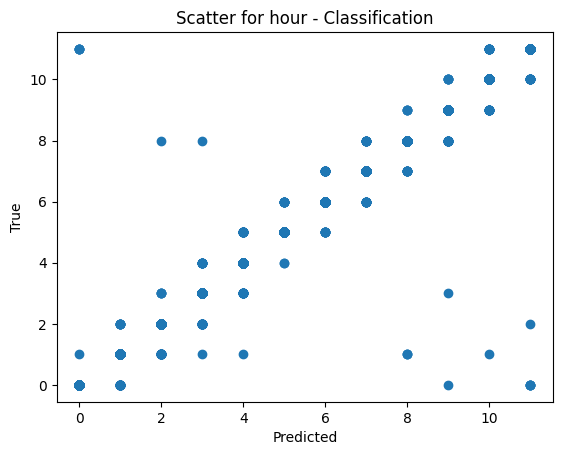

In [ ]:
# Scatter plot to show deviation for hour from Real to Pred

plt.scatter(y_pred_hours, y_test_hours_real)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes_real =  y_test[:,1]

# Convert the sin and cos values back to minutes
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)

abs_mins = abs(y_pred_mins - y_test_minutes_real)
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

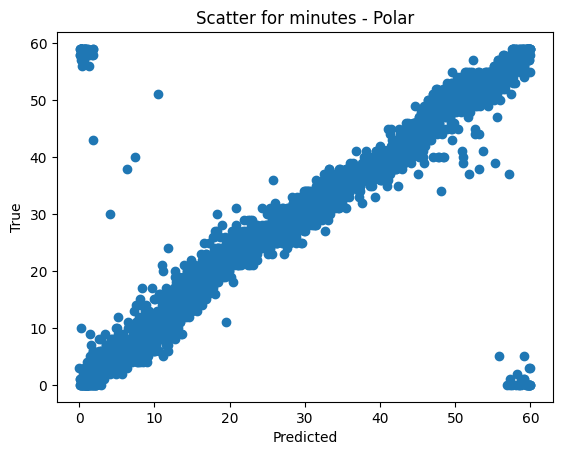

In [ ]:
# Scatter plot to show deviation for minutes from Real to Pred
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

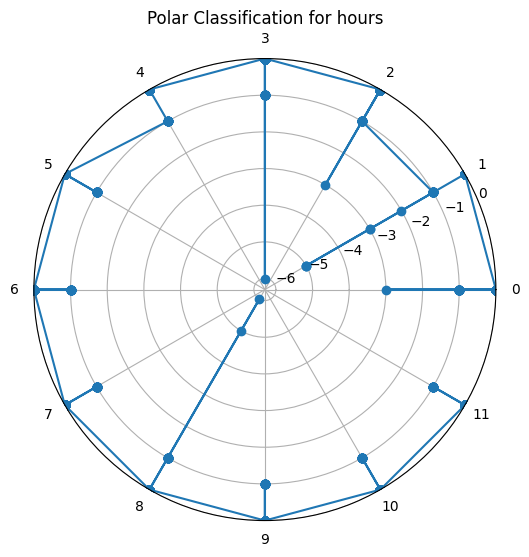

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours_real)
sorted_y_test_hr = y_test_hours_real[sorted_indices_hr]

# Create polar plot to show common sense error for hour from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Polar Classification for hours")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

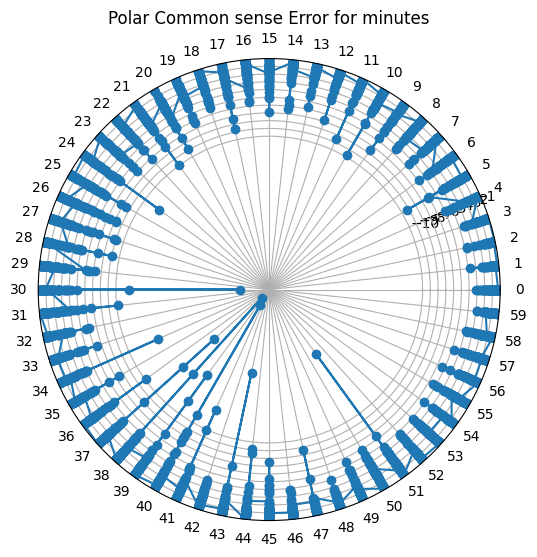

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes_real)
sorted_y_test_min = y_test_minutes_real[sorted_indices_min]

# Create polar plot to show common sense error for minutes from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Polar Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

2024-11-08 14:49:45.270058: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-08 14:49:45.286613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 14:49:45.308606: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 14:49:45.315272: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 14:49:45.332076: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=45) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 100

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    c11 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    m11 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c11)
    b11 = keras.layers.BatchNormalization()(m11)
    
    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b11)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-08 14:49:53.638865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22461 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-11-08 14:49:53.639853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22461 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 50, 50,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 50,    │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 50, 50,    │     25,632 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 5, 5, 64)  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 5, 5, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 5, 128) │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 2, 2, 128) │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 2, 2, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2, 2, 256) │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 1, 1, 256) │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │                   │            │                 

 Total params: 688,878 (2.63 MB)

 Trainable params: 687,854 (2.62 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


I0000 00:00:1731095400.878388   47345 service.cc:146] XLA service 0x7f9050007340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731095400.878433   47345 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1731095400.878445   47345 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-08 14:50:01.063666: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-08 14:50:01.621398: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-08 14:50:05.746250: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads



 14/225 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - dense_1_accuracy: 0.0776 - dense_1_loss: 2.9931 - dense_5_loss: 0.4355 - dense_5_mae: 0.8084 - loss: 3.4286

I0000 00:00:1731095415.703588   47345 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


221/225 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - dense_1_accuracy: 0.1094 - dense_1_loss: 2.6820 - dense_5_loss: 0.3137 - dense_5_mae: 0.6864 - loss: 2.9957

2024-11-08 14:50:27.204340: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_372', 8 bytes spill stores, 8 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 70ms/step - dense_1_accuracy: 0.1102 - dense_1_loss: 2.6766 - dense_5_loss: 0.3126 - dense_5_mae: 0.6851 - loss: 2.9892 - val_dense_1_accuracy: 0.0811 - val_dense_1_loss: 2.5951 - val_dense_5_loss: 0.2521 - val_dense_5_mae: 0.6382 - val_loss: 2.8416 - learning_rate: 0.0010
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - dense_1_accuracy: 0.3185 - dense_1_loss: 1.7388 - dense_5_loss: 0.2022 - dense_5_mae: 0.5378 - loss: 1.9410 - val_dense_1_accuracy: 0.0811 - val_dense_1_loss: 3.1374 - val_dense_5_loss: 0.2504 - val_dense_5_mae: 0.6362 - val_loss: 3.3831 - learning_rate: 0.0010
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - dense_1_accuracy: 0.6503 - dense_1_loss: 0.8579 - dense_5_loss: 0.2158 - dense_5_mae: 0.5697 - loss: 1.0737 - val_dense_1_accuracy: 0.4194 - val_dense_1_loss: 1.5200 - val_dense_5_loss: 0.2169 - val_dense_5_mae: 0.5619 - val_loss: 1.7374 - learning_rate: 0.0010
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - d

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

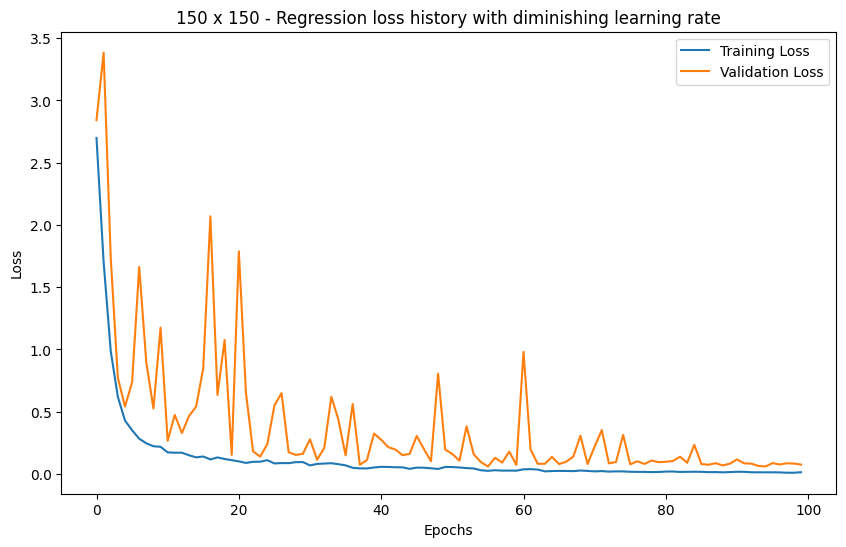

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours_real = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours_real)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

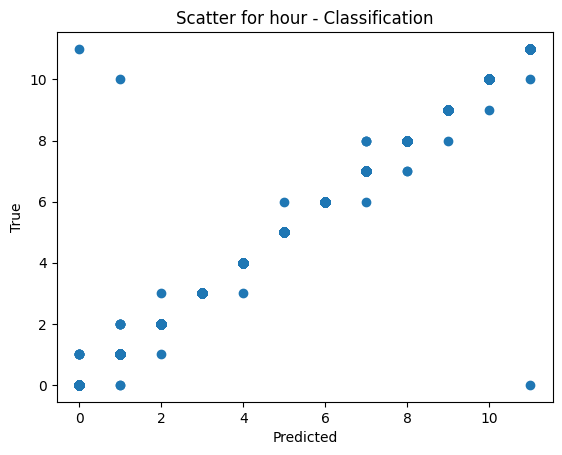

In [ ]:
# Scatter plot to show deviation for hour from Real to Pred

plt.scatter(y_pred_hours, y_test_hours_real)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes_real =  y_test[:,1]

# Convert the sin and cos values back to minutes
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)

abs_mins = abs(y_pred_mins - y_test_minutes_real)
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

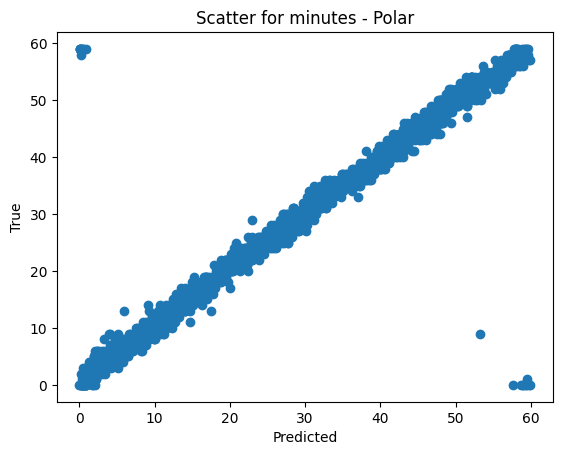

In [ ]:
# Scatter plot to show deviation for minutes from Real to Pred
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

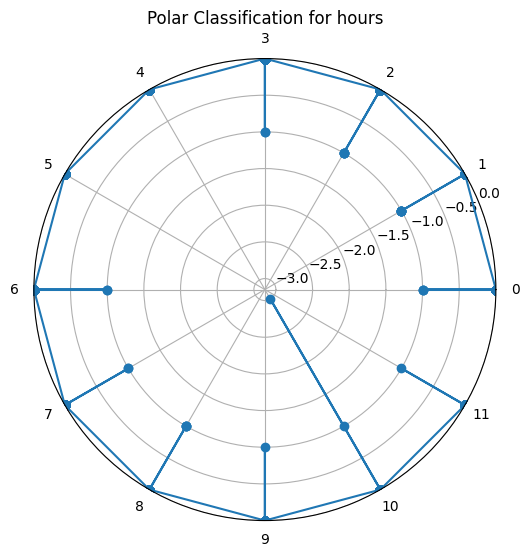

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours_real)
sorted_y_test_hr = y_test_hours_real[sorted_indices_hr]

# Create polar plot to show common sense error for hour from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Polar Classification for hours")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

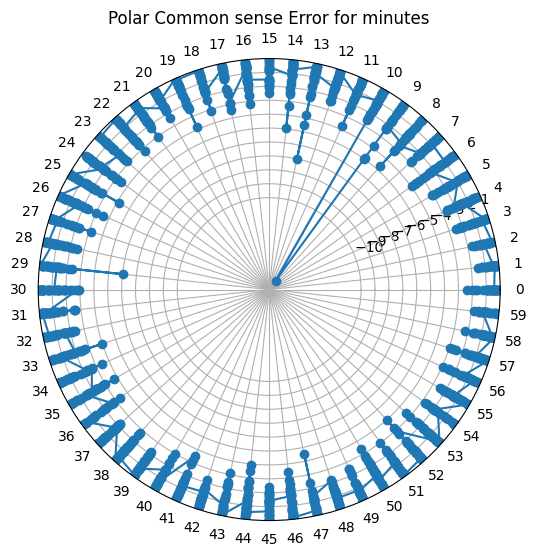

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes_real)
sorted_y_test_min = y_test_minutes_real[sorted_indices_min]

# Create polar plot to show common sense error for minutes from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Polar Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
score = model.evaluate(x_test_reshaped, [y_test_hours, y_test_minutes], verbose=False) 

In [ ]:
for each in history.history.keys():
    print(f"Train {each}: {history.history[each][-1]}")

print(f"\nTest dense_19_accuracy: {score[3]}")
print(f"Test dense_19_loss: {score[0]}")
print(f"Test dense_23_loss: {score[1]}")
print(f"Test dense_23_mae: {score[2]}")
print(f"Test loss: {score[4]}\n")

print(f"Common Sense MAE Min Test: {np.mean(cse_min/60)}")

Train dense_1_accuracy: 0.9983333349227905
Train dense_1_loss: 0.006492764223366976
Train dense_5_loss: 0.007608402986079454
Train dense_5_mae: 0.08951189368963242
Train loss: 0.01410116720944643
Train val_dense_1_accuracy: 0.9816666841506958
Train val_dense_1_loss: 0.06728015840053558
Train val_dense_5_loss: 0.007563335821032524
Train val_dense_5_mae: 0.09109048545360565
Train val_loss: 0.07551414519548416
Train learning_rate: 0.0002621440216898918

Test dense_19_accuracy: 0.9838888645172119
Test dense_19_loss: 0.059512823820114136
Test dense_23_loss: 0.05244996398687363
Test dense_23_mae: 0.006393952760845423
Test loss: 0.08442267775535583

Common Sense MAE Min Test: 0.018798337834731983


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=45) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    c11 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    m11 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c11)
    b11 = keras.layers.BatchNormalization()(m11)
    
    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b11)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
    
    
    #4th layers
    c5 = keras.layers.Conv2D(512, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b4)
    d5 = keras.layers.Dropout(0.10)(c5)
    m5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d5)
    b5 = keras.layers.BatchNormalization()(m5)

    #final layer begins
    f = keras.layers.Flatten()(b5)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 150, 150,  │        832 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 50, 50,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        128 │ max_pooling2d_5[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 50, 50,    │     25,632 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 5, 5, 64)  │          0 │ dropout_7[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 5, 5, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 5, 5, 128) │          0 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 2, 2, 128) │          0 │ dropout_8[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 2, 2, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 2, 2, 256) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 1, 1, 256) │          0 │ dropout_9[0][0]   │
│ (MaxPooling2D)      │                   │            │                 

 Total params: 1,707,246 (6.51 MB)

 Trainable params: 1,705,198 (6.50 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node functional_1_1/max_pooling2d_10_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](functional_1_1/dropout_10_1/stateless_dropout/SelectV2)' with input shapes: [64,1,1,512].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(64, 1, 1, 512), dtype=float32)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

: 

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

: 

In [ ]:
y_pred = model.predict(x_test)

: 

In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours_real = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours_real)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

: 

In [ ]:
# Scatter plot to show deviation for hour from Real to Pred

plt.scatter(y_pred_hours, y_test_hours_real)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

: 

In [ ]:
y_test_minutes_real =  y_test[:,1]

# Convert the sin and cos values back to minutes
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)

abs_mins = abs(y_pred_mins - y_test_minutes_real)
cse_min = np.minimum(abs_mins, 60. - abs_mins)

: 

In [ ]:
# Scatter plot to show deviation for minutes from Real to Pred
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

: 

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours_real)
sorted_y_test_hr = y_test_hours_real[sorted_indices_hr]

# Create polar plot to show common sense error for hour from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Polar Classification for hours")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

: 

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes_real)
sorted_y_test_min = y_test_minutes_real[sorted_indices_min]

# Create polar plot to show common sense error for minutes from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Polar Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
# ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

: 

In [ ]:
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
score = model.evaluate(x_test_reshaped, [y_test_hours, y_test_minutes], verbose=False) 

: 

In [ ]:
for each in history.history.keys():
    print(f"Train {each}: {history.history[each][-1]}")

print(f"\nTest dense_19_accuracy: {score[3]}")
print(f"Test dense_19_loss: {score[0]}")
print(f"Test dense_23_loss: {score[1]}")
print(f"Test dense_23_mae: {score[2]}")
print(f"Test loss: {score[4]}\n")

print(f"Common Sense MAE Min Test: {np.mean(cse_min/60)}")

: 

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=45) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    c1 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    c11 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    m11 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c11)
    b11 = keras.layers.BatchNormalization()(m11)
    
    #2nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b11)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #3rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #4th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
    
    
    #4th layers
    # c5 = keras.layers.Conv2D(512, kernel_size=(3, 3),
    #                     activation='relu',padding='same',
    #                     input_shape=input_shape)(b4)
    # d5 = keras.layers.Dropout(0.10)(c5)
    # m5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d5)
    # b5 = keras.layers.BatchNormalization()(m5)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 150, 150,  │        832 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 50, 50,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        128 │ max_pooling2d_11… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 50, 50,    │     25,632 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ max_pooling2d_12… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 16, 16,    │          0 │ conv2d_13[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 5, 5, 64)  │          0 │ dropout_15[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ max_pooling2d_13… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 5, 5, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 5, 5, 128) │          0 │ conv2d_14[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 2, 2, 128) │          0 │ dropout_16[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ max_pooling2d_14… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 2, 2, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 2, 2, 256) │          0 │ conv2d_15[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 688,878 (2.63 MB)

 Trainable params: 687,854 (2.62 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - dense_13_accuracy: 0.1112 - dense_13_loss: 2.6462 - dense_17_loss: 0.2959 - dense_17_mae: 0.6680 - loss: 2.9420 - val_dense_13_accuracy: 0.0806 - val_dense_13_loss: 2.8029 - val_dense_17_loss: 0.2534 - val_dense_17_mae: 0.6378 - val_loss: 3.0656 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - dense_13_accuracy: 0.3351 - dense_13_loss: 1.6793 - dense_17_loss: 0.2051 - dense_17_mae: 0.5446 - loss: 1.8844 - val_dense_13_accuracy: 0.1044 - val_dense_13_loss: 2.8527 - val_dense_17_loss: 0.2490 - val_dense_17_mae: 0.6344 - val_loss: 3.1051 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - dense_13_accuracy: 0.6428 - dense_13_loss: 0.8566 - dense_17_loss: 0.2032 - dense_17_mae: 0.5474 - loss: 1.0598 - val_dense_13_accuracy: 0.5950 - val_dense_13_loss: 1.0247 - val_dense_17_loss: 0.1801 - val_dense_17_mae: 0.4968 - val_loss: 1.2009 - learning_rate: 0.0010
Epoch 4/500
225/225 ━

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

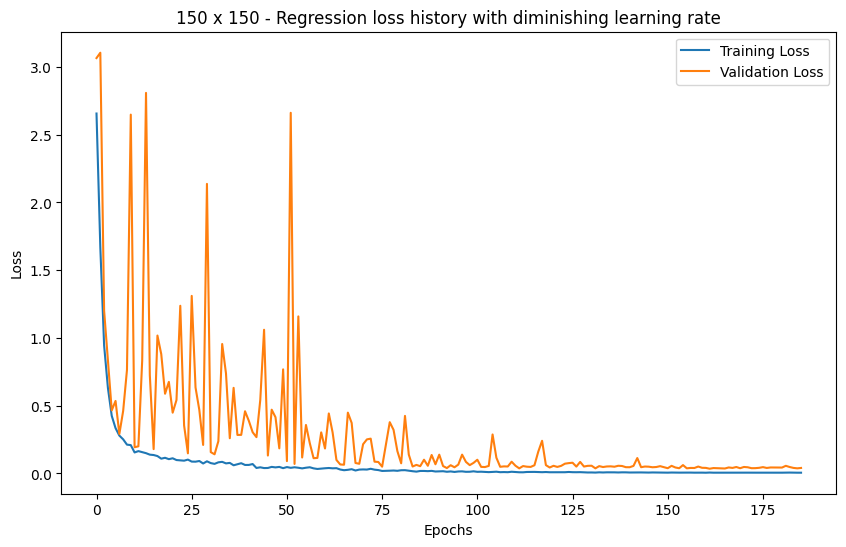

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours_real = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours_real)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

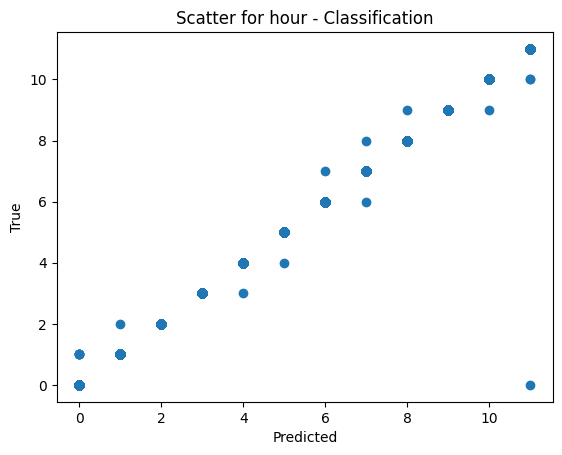

In [ ]:
# Scatter plot to show deviation for hour from Real to Pred

plt.scatter(y_pred_hours, y_test_hours_real)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes_real =  y_test[:,1]

# Convert the sin and cos values back to minutes
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)

abs_mins = abs(y_pred_mins - y_test_minutes_real)
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

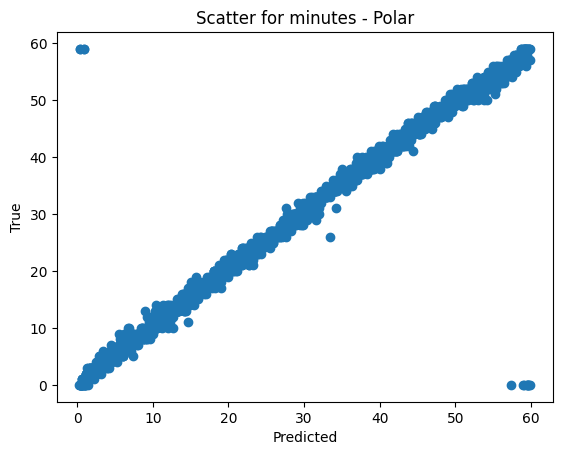

In [ ]:
# Scatter plot to show deviation for minutes from Real to Pred
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

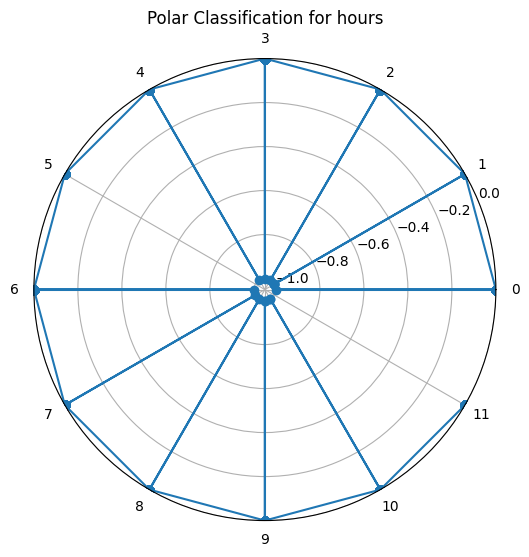

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours_real)
sorted_y_test_hr = y_test_hours_real[sorted_indices_hr]

# Create polar plot to show common sense error for hour from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Polar Classification for hours")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

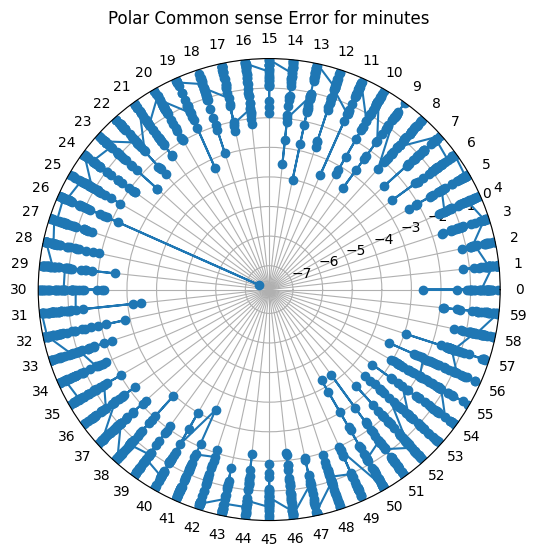

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes_real)
sorted_y_test_min = y_test_minutes_real[sorted_indices_min]

# Create polar plot to show common sense error for minutes from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Polar Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
# ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
score = model.evaluate(x_test_reshaped, [y_test_hours, y_test_minutes], verbose=False) 

In [ ]:
for each in history.history.keys():
    print(f"Train {each}: {history.history[each][-1]}")

print(f"\nTest dense_19_accuracy: {score[3]}")
print(f"Test dense_19_loss: {score[0]}")
print(f"Test dense_23_loss: {score[1]}")
print(f"Test dense_23_mae: {score[2]}")
print(f"Test loss: {score[4]}\n")

print(f"Common Sense MAE Min Test: {np.mean(cse_min/60)}")

Train dense_13_accuracy: 0.99979168176651
Train dense_13_loss: 0.0007502776570618153
Train dense_17_loss: 0.004642076324671507
Train dense_17_mae: 0.07009832561016083
Train loss: 0.0053923544473946095
Train val_dense_13_accuracy: 0.9905555844306946
Train val_dense_13_loss: 0.03668036311864853
Train val_dense_17_loss: 0.0027336275670677423
Train val_dense_17_mae: 0.05437241122126579
Train val_loss: 0.040449123829603195
Train learning_rate: 4.3980468035442755e-05

Test dense_19_accuracy: 0.9911110997200012
Test dense_19_loss: 0.04735849052667618
Test dense_23_loss: 0.043126657605171204
Test dense_23_mae: 0.0037054128479212523
Test loss: 0.062248557806015015

Common Sense MAE Min Test: 0.014194660820066929


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=45) 
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

# y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
# y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    # x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    # x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    #1st Layer
    c1 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c11 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    m11 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c11)
    b11 = keras.layers.BatchNormalization()(m11)
    
    #3nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b11)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #4rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #5th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
    
    
    #4th layers
    # c5 = keras.layers.Conv2D(512, kernel_size=(3, 3),
    #                     activation='relu',padding='same',
    #                     input_shape=input_shape)(b4)
    # d5 = keras.layers.Dropout(0.10)(c5)
    # m5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d5)
    # b5 = keras.layers.BatchNormalization()(m5)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 150, 150,  │        832 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 50, 50,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        128 │ max_pooling2d_16… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 50, 50,    │     25,632 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 16, 16,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ max_pooling2d_17… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 16, 16,    │          0 │ conv2d_18[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 5, 5, 64)  │          0 │ dropout_22[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ max_pooling2d_18… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 5, 5, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 5, 5, 128) │          0 │ conv2d_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 2, 2, 128) │          0 │ dropout_23[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ max_pooling2d_19… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 2, 2, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 2, 2, 256) │          0 │ conv2d_20[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 688,878 (2.63 MB)

 Trainable params: 687,854 (2.62 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                # validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping]
)

Epoch 1/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - dense_19_accuracy: 0.1309 - dense_19_loss: 2.6058 - dense_23_loss: 0.2819 - dense_23_mae: 0.6457 - loss: 2.8877
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - dense_19_accuracy: 0.3616 - dense_19_loss: 1.6248 - dense_23_loss: 0.2060 - dense_23_mae: 0.5455 - loss: 1.8309
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - dense_19_accuracy: 0.6542 - dense_19_loss: 0.8649 - dense_23_loss: 0.1992 - dense_23_mae: 0.5399 - loss: 1.0641
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - dense_19_accuracy: 0.7874 - dense_19_loss: 0.5454 - dense_23_loss: 0.1082 - dense_23_mae: 0.3606 - loss: 0.6536
Epoch 5/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - dense_19_accuracy: 0.8540 - dense_19_loss: 0.3751 - dense_23_loss: 0.0691 - dense_23_mae: 0.2786 - loss: 0.4441
Epoch 6/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - dense_19_accuracy: 0.8885 - dense_19_loss: 0.2974 - dense_23_loss: 0.0555 - dense_23_mae: 0.2461 - loss

In [ ]:
loss = history.history['loss']
# val_loss = history.history['val_loss']

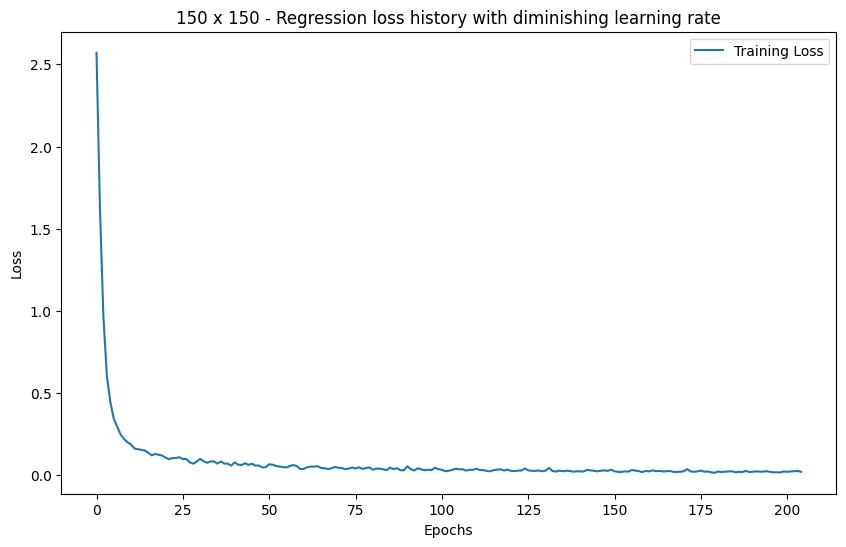

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours_real = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours_real)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

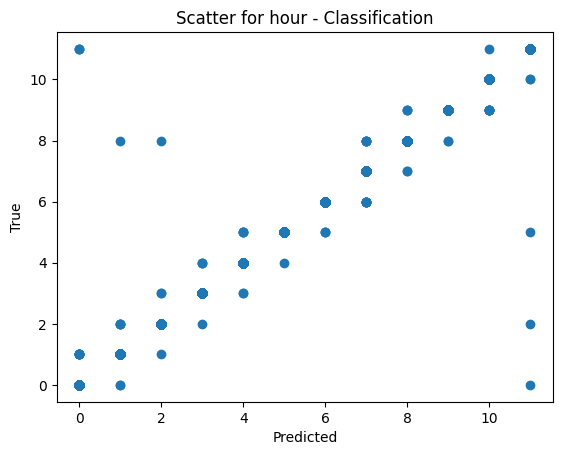

In [ ]:
# Scatter plot to show deviation for hour from Real to Pred

plt.scatter(y_pred_hours, y_test_hours_real)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes_real =  y_test[:,1]

# Convert the sin and cos values back to minutes
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)

abs_mins = abs(y_pred_mins - y_test_minutes_real)
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

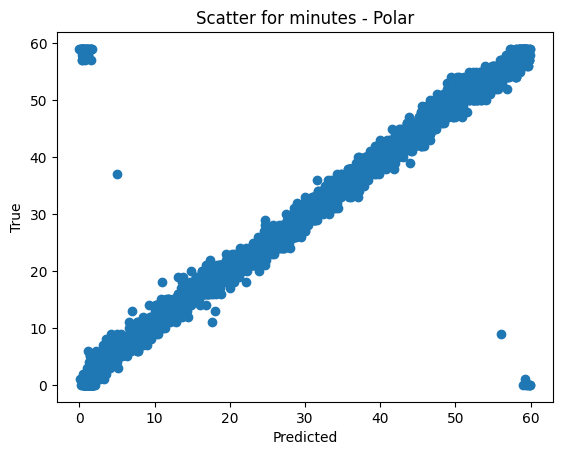

In [ ]:
# Scatter plot to show deviation for minutes from Real to Pred
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

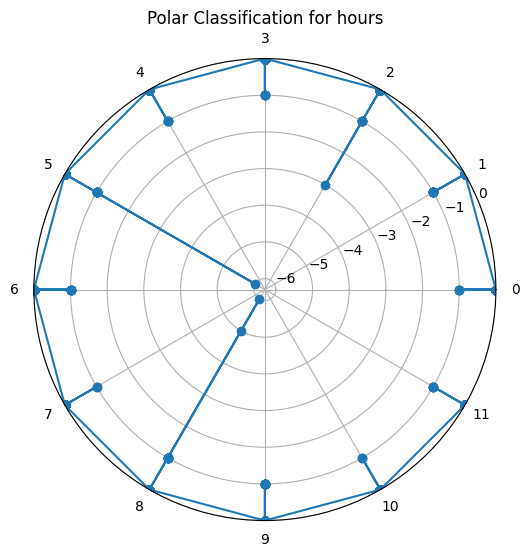

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours_real)
sorted_y_test_hr = y_test_hours_real[sorted_indices_hr]

# Create polar plot to show common sense error for hour from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Polar Classification for hours")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

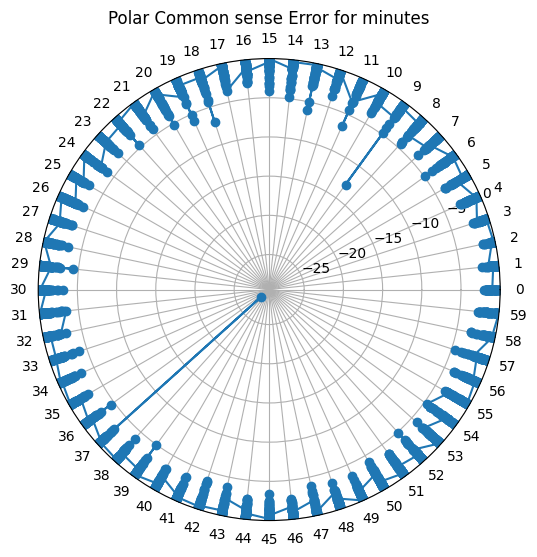

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes_real)
sorted_y_test_min = y_test_minutes_real[sorted_indices_min]

# Create polar plot to show common sense error for minutes from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Polar Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
# ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
score = model.evaluate(x_test_reshaped, [y_test_hours, y_test_minutes], verbose=False) 

In [ ]:
for each in history.history.keys():
    print(f"Train {each}: {history.history[each][-1]}")

print(f"\nTest dense_19_accuracy: {score[3]}")
print(f"Test dense_19_loss: {score[0]}")
print(f"Test dense_23_loss: {score[1]}")
print(f"Test dense_23_mae: {score[2]}")
print(f"Test loss: {score[4]}\n")

print(f"Common Sense MAE Min Test: {np.mean(cse_min/60)}")

Train dense_19_accuracy: 0.9967361092567444
Train dense_19_loss: 0.011585216969251633
Train dense_23_loss: 0.008260559290647507
Train dense_23_mae: 0.09183710813522339
Train loss: 0.01984577812254429

Test dense_19_accuracy: 0.9811111092567444
Test dense_19_loss: 0.08623848855495453
Test dense_23_loss: 0.08074290305376053
Test dense_23_mae: 0.005968359299004078
Test loss: 0.07701487839221954

Common Sense MAE Min Test: 0.018575965392105796


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images_150.npy")
labels = np.load("A1/data/labels_150.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=45) 
# x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

# y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
# y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    # x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    # x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    #1st Layer
    c1 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c11 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    m11 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c11)
    b11 = keras.layers.BatchNormalization()(m11)
    
    #3nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b11)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #4rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #5th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
    
    
    #4th layers
    # c5 = keras.layers.Conv2D(512, kernel_size=(3, 3),
    #                     activation='relu',padding='same',
    #                     input_shape=input_shape)(b4)
    # d5 = keras.layers.Dropout(0.10)(c5)
    # m5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d5)
    # b5 = keras.layers.BatchNormalization()(m5)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

/local/s3777103/IDL-11/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 150, 150,  │        832 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 50, 50,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        128 │ max_pooling2d_21… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 50, 50,    │     25,632 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 16, 16,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ max_pooling2d_22… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 16, 16,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 5, 5, 64)  │          0 │ dropout_29[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 5, 64)  │        256 │ max_pooling2d_23… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 5, 5, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 5, 5, 128) │          0 │ conv2d_24[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 2, 2, 128) │          0 │ dropout_30[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ max_pooling2d_24… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 2, 2, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 2, 2, 256) │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 688,878 (2.63 MB)

 Trainable params: 687,854 (2.62 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                # validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - dense_25_accuracy: 0.1181 - dense_25_loss: 2.6629 - dense_29_loss: 0.2944 - dense_29_mae: 0.6683 - loss: 2.9572 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - dense_25_accuracy: 0.3372 - dense_25_loss: 1.6810 - dense_29_loss: 0.2022 - dense_29_mae: 0.5362 - loss: 1.8832 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - dense_25_accuracy: 0.6700 - dense_25_loss: 0.8132 - dense_29_loss: 0.2099 - dense_29_mae: 0.5598 - loss: 1.0231 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - dense_25_accuracy: 0.8190 - dense_25_loss: 0.4825 - dense_29_loss: 0.1273 - dense_29_mae: 0.4010 - loss: 0.6098 - learning_rate: 0.0010
Epoch 5/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - dense_25_accuracy: 0.8711 - dense_25_loss: 0.3535 - dense_29_loss: 0.0762 - dense_29_mae: 0.2938 - loss: 0.4297 - learning_rate: 0.0010
Epoch 6/500
225/225 ━━━━━━━━━━━━━━━━━━━

In [ ]:
loss = history.history['loss']
# val_loss = history.history['val_loss']

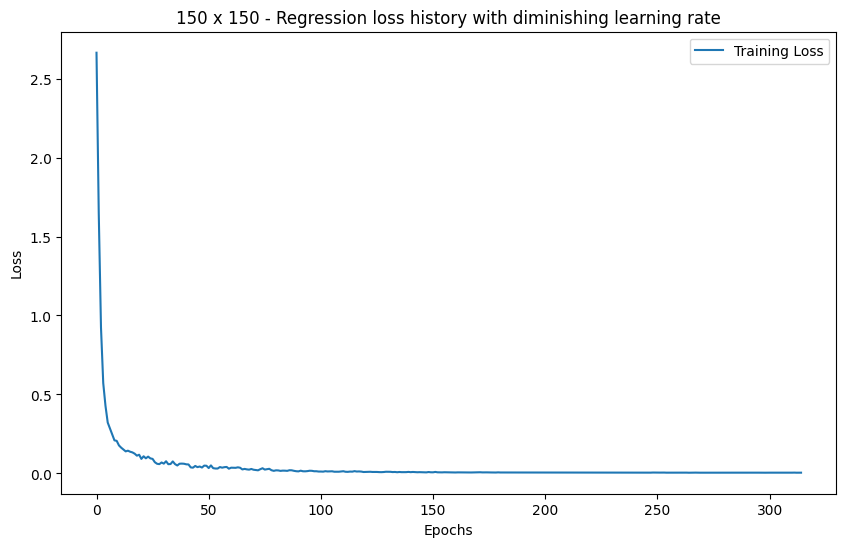

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours_real = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours_real)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

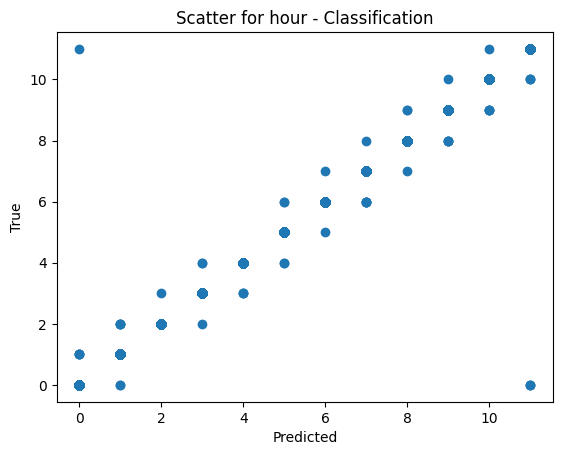

In [ ]:
# Scatter plot to show deviation for hour from Real to Pred

plt.scatter(y_pred_hours, y_test_hours_real)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes_real =  y_test[:,1]

# Convert the sin and cos values back to minutes
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)

abs_mins = abs(y_pred_mins - y_test_minutes_real)
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

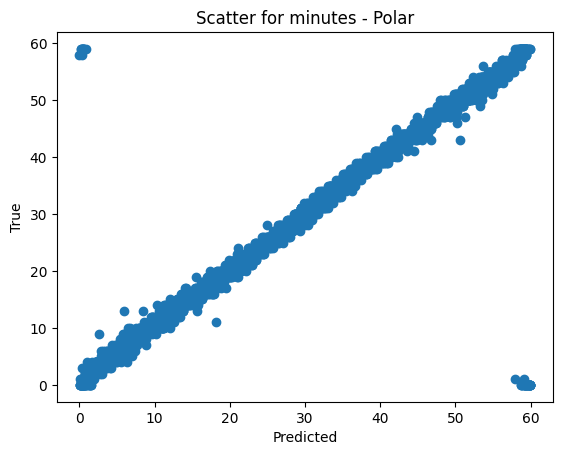

In [ ]:
# Scatter plot to show deviation for minutes from Real to Pred
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

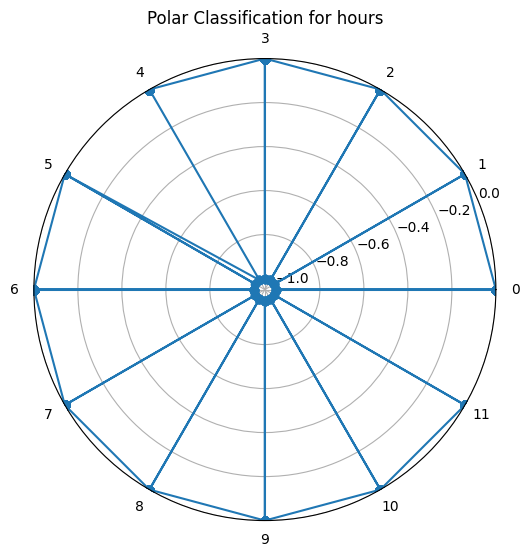

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours_real)
sorted_y_test_hr = y_test_hours_real[sorted_indices_hr]

# Create polar plot to show common sense error for hour from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Polar Classification for hours")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)

ax.set_xticklabels(range(12))

plt.show()

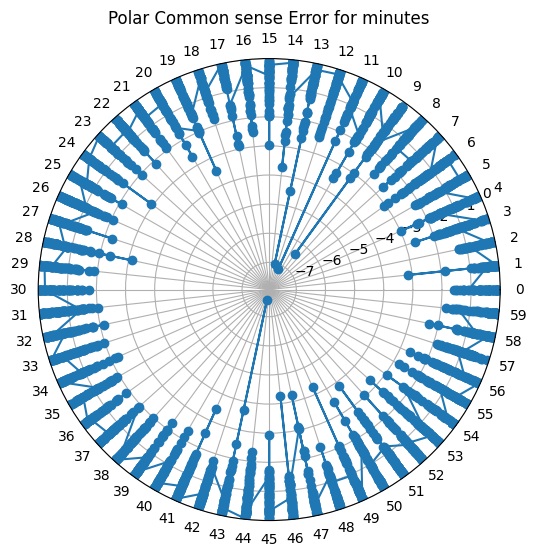

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes_real)
sorted_y_test_min = y_test_minutes_real[sorted_indices_min]

# Create polar plot to show common sense error for minutes from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Polar Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
# ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
score = model.evaluate(x_test_reshaped, [y_test_hours, y_test_minutes], verbose=False) 

In [ ]:
for each in history.history.keys():
    print(f"Train {each}: {history.history[each][-1]}")

print(f"\nTest dense_19_accuracy: {score[3]}")
print(f"Test dense_19_loss: {score[0]}")
print(f"Test dense_23_loss: {score[1]}")
print(f"Test dense_23_mae: {score[2]}")
print(f"Test loss: {score[4]}\n")

print(f"Common Sense MAE Min Test: {np.mean(cse_min/60)}")

Train dense_25_accuracy: 0.9998611211776733
Train dense_25_loss: 0.00044065501424483955
Train dense_29_loss: 0.004218609072268009
Train dense_29_mae: 0.06680667400360107
Train loss: 0.004659262951463461
Train learning_rate: 3.0223150133679155e-06

Test dense_19_accuracy: 0.9863888621330261
Test dense_19_loss: 0.05810726061463356
Test dense_23_loss: 0.055073048919439316
Test dense_23_mae: 0.0028153446037322283
Test loss: 0.054267916828393936

Common Sense MAE Min Test: 0.012748698218676037


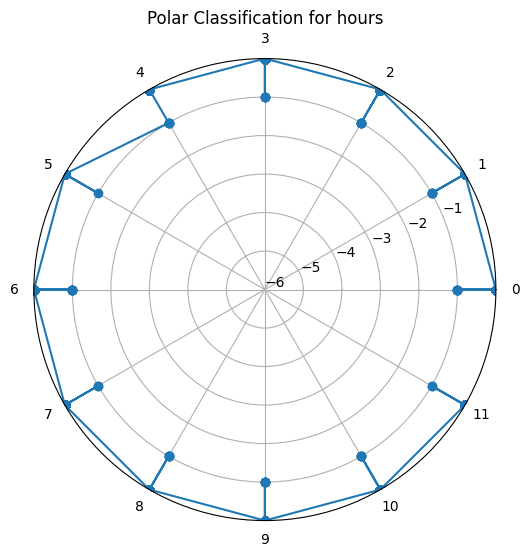

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours_real)
sorted_y_test_hr = y_test_hours_real[sorted_indices_hr]

# Create polar plot to show common sense error for hour from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Polar Classification for hours")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)
ax.set_yticks(np.arange(-6, 0))
ax.set_xticklabels(range(12))

plt.show()

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images.npy")
labels = np.load("A1/data/labels.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=45) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    #1st Layer
    c1 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    # #2nd layers
    # c11 = keras.layers.Conv2D(32, kernel_size=(5, 5),
    #                     activation='relu',padding='same',
    #                     input_shape=input_shape)(b1)
    # m11 = keras.layers.MaxPooling2D(pool_size=(3, 3))(c11)
    # b11 = keras.layers.BatchNormalization()(m11)
    
    #3nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    d2=  keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(3, 3))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #4rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #5th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
    
    
    #4th layers
    # c5 = keras.layers.Conv2D(512, kernel_size=(3, 3),
    #                     activation='relu',padding='same',
    #                     input_shape=input_shape)(b4)
    # d5 = keras.layers.Dropout(0.10)(c5)
    # m5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d5)
    # b5 = keras.layers.BatchNormalization()(m5)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    #for hours final layers
    dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(2, activation='tanh')(minute_dropout3)

    # final model
    model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    
    model.compile(optimizer="adam", 
                  loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 75, 75,    │        832 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 25, 25,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        128 │ max_pooling2d_31… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 25, 25,    │     51,264 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 25, 25,    │          0 │ conv2d_32[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 8, 8, 64)  │          0 │ dropout_43[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ max_pooling2d_32… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 8, 8, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 8, 8, 128) │          0 │ conv2d_33[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 4, 4, 128) │          0 │ dropout_44[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ max_pooling2d_33… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 4, 4, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 4, 4, 256) │          0 │ conv2d_34[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_34    │ (None, 2, 2, 256) │          0 │ dropout_45[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 256) │      1,024 │ max_pooling2d_34… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 512)       │    524,800 │ flatten_6[0][0] 

 Total params: 1,154,638 (4.40 MB)

 Trainable params: 1,153,678 (4.40 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Initialize EarlyStopping with patience
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=25,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.8, patience=5, min_lr=1e-6, cooldown=5
)


history = model.fit(x_train, [y_train_hours, y_train_minutes],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, [y_val_hours, y_val_minutes]),
                callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500


2024-11-08 17:47:32.902061: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 4 bytes spill stores, 4 bytes spill loads

2024-11-08 17:47:35.233806: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 16 bytes spill stores, 16 bytes spill loads

2024-11-08 17:47:35.367787: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 12 bytes spill stores, 12 bytes spill loads

2024-11-08 17:47:35.641727: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 108 bytes spill stores, 108 bytes spill loads

2024-11-08 17:47:35.653223: I external/local_xla/xla/stream_executor/cuda/

225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - dense_37_accuracy: 0.0843 - dense_37_loss: 2.5700 - dense_41_loss: 0.3115 - dense_41_mae: 0.6875 - loss: 2.8815 - val_dense_37_accuracy: 0.0889 - val_dense_37_loss: 2.6867 - val_dense_41_loss: 0.2518 - val_dense_41_mae: 0.6375 - val_loss: 2.9514 - learning_rate: 0.0010
Epoch 2/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - dense_37_accuracy: 0.1494 - dense_37_loss: 2.3006 - dense_41_loss: 0.2287 - dense_41_mae: 0.5916 - loss: 2.5292 - val_dense_37_accuracy: 0.0839 - val_dense_37_loss: 2.6071 - val_dense_41_loss: 0.2582 - val_dense_41_mae: 0.6424 - val_loss: 2.8652 - learning_rate: 0.0010
Epoch 3/500
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - dense_37_accuracy: 0.4008 - dense_37_loss: 1.4111 - dense_41_loss: 0.2057 - dense_41_mae: 0.5471 - loss: 1.6169 - val_dense_37_accuracy: 0.5694 - val_dense_37_loss: 1.0399 - val_dense_41_loss: 0.2006 - val_dense_41_mae: 0.5192 - val_loss: 1.2452 - learning_rate: 0.0010
Epoch 4/500
225/225 ━━━━━━━━━━━━━━━

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

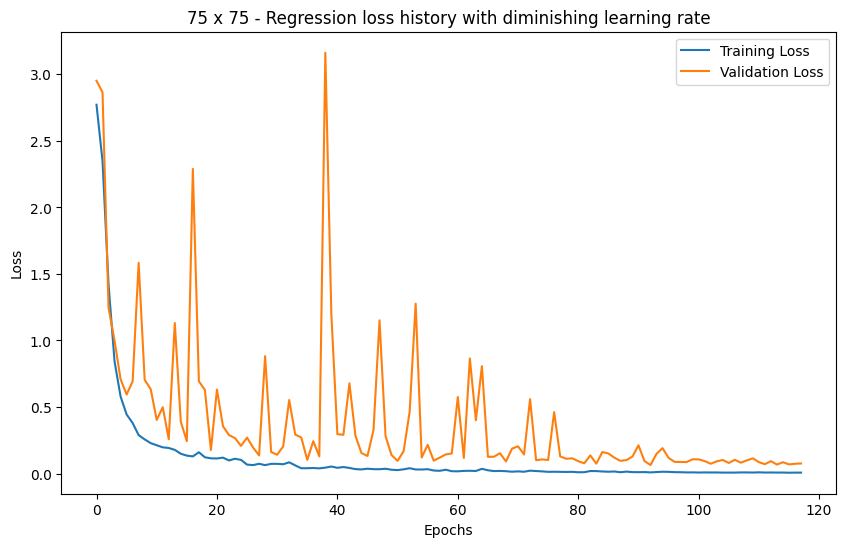

In [ ]:
# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'{img_rows} x {img_cols} - Regression loss history with diminishing learning rate')
plt.legend()
plt.show()
plt.close()

In [ ]:
y_pred = model.predict(x_test)

2024-11-08 17:51:18.308206: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 12 bytes spill stores, 12 bytes spill loads

2024-11-08 17:51:18.466052: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 32 bytes spill stores, 32 bytes spill loads



57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


In [ ]:
y_pred_hours = np.argmax(y_pred[0], axis=1)
y_test_hours_real = y_test[:,0]

abs_hr = np.abs(y_pred_hours - y_test_hours_real)
cse_hr = np.minimum(abs_hr, 12 - abs_hr)

Text(0.5, 1.0, 'Scatter for hour - Classification')

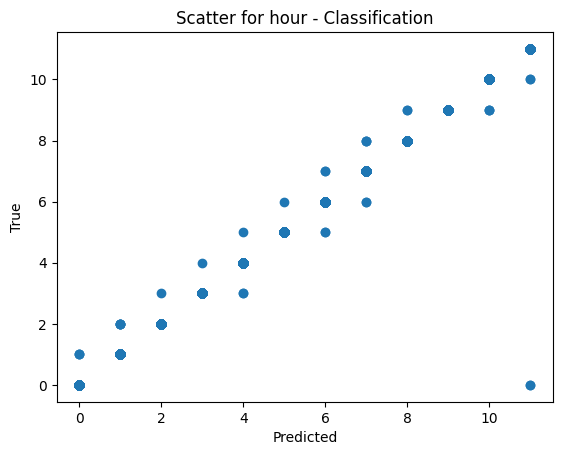

In [ ]:
# Scatter plot to show deviation for hour from Real to Pred

plt.scatter(y_pred_hours, y_test_hours_real)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for hour - Classification')

In [ ]:
y_test_minutes_real =  y_test[:,1]

# Convert the sin and cos values back to minutes
y_pred_mins = (np.arctan2(y_pred[1][:,1], y_pred[1][:,0]) % (2 * np.pi)) *  60 / (2 * np.pi)

abs_mins = abs(y_pred_mins - y_test_minutes_real)
cse_min = np.minimum(abs_mins, 60. - abs_mins)

Text(0.5, 1.0, 'Scatter for minutes - Polar')

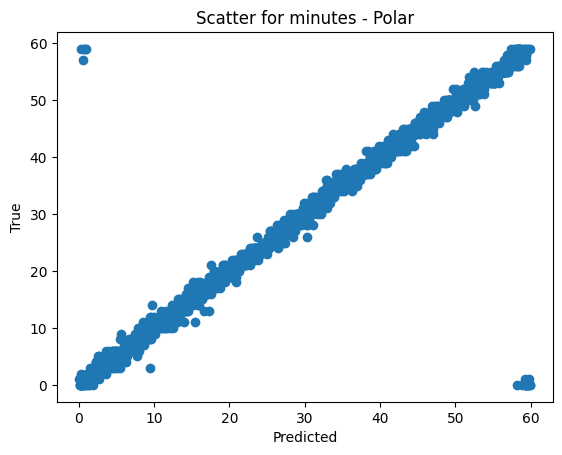

In [ ]:
# Scatter plot to show deviation for minutes from Real to Pred
plt.scatter(y_pred_mins, y_test[:,1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Scatter for minutes - Polar')

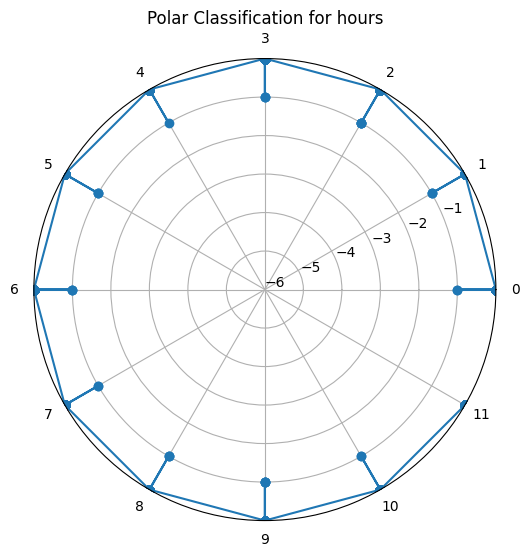

In [ ]:
sorted_indices_hr = np.argsort(y_test_hours_real)
sorted_y_test_hr = y_test_hours_real[sorted_indices_hr]

# Create polar plot to show common sense error for hour from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_hr/12, -cse_hr[sorted_indices_hr], marker='o')

# Add title and show plot
ax.set_title("Polar Classification for hours")
theta_ticks = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 hours around the clock
ax.set_xticks(theta_ticks)
ax.set_yticks(np.arange(-6, 0))
ax.set_xticklabels(range(12))

plt.show()

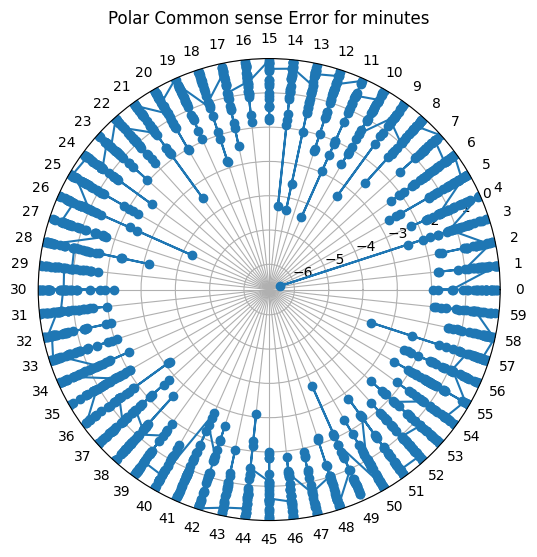

In [ ]:
sorted_indices_min = np.argsort(y_test_minutes_real)
sorted_y_test_min = y_test_minutes_real[sorted_indices_min]

# Create polar plot to show common sense error for minutes from Real to Pred
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(2 * np.pi * sorted_y_test_min/60, -cse_min[sorted_indices_min], marker='o')

# Add title and show plot
ax.set_title("Polar Common sense Error for minutes")
theta_ticks = np.linspace(0, 2 * np.pi, 60, endpoint=False)  # 60 mins around the clock
ax.set_xticks(theta_ticks)
# ax.set_yticks(np.arange(-10, 0))
ax.set_xticklabels(range(60))

plt.show()

In [ ]:
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
score = model.evaluate(x_test_reshaped, [y_test_hours, y_test_minutes], verbose=False) 

In [ ]:
for each in history.history.keys():
    print(f"Train {each}: {history.history[each][-1]}")

print(f"\nTest dense_19_accuracy: {score[3]}")
print(f"Test dense_19_loss: {score[0]}")
print(f"Test dense_23_loss: {score[1]}")
print(f"Test dense_23_mae: {score[2]}")
print(f"Test loss: {score[4]}\n")

print(f"Common Sense MAE Min Test: {np.mean(cse_min/60)}")

Train dense_37_accuracy: 0.9993749856948853
Train dense_37_loss: 0.0020225467160344124
Train dense_41_loss: 0.00511361425742507
Train dense_41_mae: 0.07368560880422592
Train loss: 0.00713615957647562
Train val_dense_37_accuracy: 0.9827777743339539
Train val_dense_37_loss: 0.07143575698137283
Train val_dense_41_loss: 0.0027195275761187077
Train val_dense_41_mae: 0.053643688559532166
Train val_loss: 0.07609926909208298
Train learning_rate: 0.00010737419506767765

Test dense_19_accuracy: 0.9822221994400024
Test dense_19_loss: 0.08812841773033142
Test dense_23_loss: 0.08392082899808884
Test dense_23_mae: 0.0031468532979488373
Test loss: 0.05732259899377823

Common Sense MAE Min Test: 0.013132589380291325


: 

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [ ]:
images = np.load("A1/data/images.npy")
labels = np.load("A1/data/labels.npy")

num_classes = len(np.unique(labels[:,0]))

In [ ]:
# Define the function to map minute to sin and cos polar coordinate values
def time_to_polar(row):
    hour_cosine = math.cos(row[0] * 2 * math.pi / 12)
    hour_sine = math.sin(row[0] * 2 * math.pi / 12)
    
    minute_cosine = math.cos(row[1] * 2 * math.pi / 60)
    minute_sine = math.sin(row[1] * 2 * math.pi / 60)
    return [hour_cosine, hour_sine, minute_cosine, minute_sine]

img_rows = images.shape[1]
img_cols = images.shape[2]

In [ ]:
images = images.astype('float32')/255.0

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=45) 
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50, random_state=33) 

In [ ]:
y_train_hours = keras.utils.to_categorical(y_train[:,0], num_classes)
y_train_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_train)

y_test_hours = keras.utils.to_categorical(y_test[:,0], num_classes)
y_test_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_test)

y_val_hours = keras.utils.to_categorical(y_val[:,0], num_classes)
y_val_minutes = np.apply_along_axis(time_to_polar, axis=1, arr=y_val)

In [ ]:
batch_size = 64
epochs = 500

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
def build_model(input_shape):
    input_ = keras.layers.Input(shape=x_train.shape[1:])

    # convolutional layers
    #1st Layer
    c1 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(input_)
    m1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c1)
    b1 = keras.layers.BatchNormalization()(m1)

    #2nd layers
    c11 = keras.layers.Conv2D(32, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b1)
    m11 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c11)
    b11 = keras.layers.BatchNormalization()(m11)
    
    #3nd layers
    c2 = keras.layers.Conv2D(64, kernel_size=(5, 5),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b11)
    d2 = keras.layers.Dropout(0.10)(c2)
    m2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d2)
    b2 = keras.layers.BatchNormalization()(m2)

    #4rd layers
    c3 = keras.layers.Conv2D(128, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b2)
    d3 = keras.layers.Dropout(0.10)(c3)
    m3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d3)
    b3 = keras.layers.BatchNormalization()(m3)

    #5th layers
    c4 = keras.layers.Conv2D(256, kernel_size=(3, 3),
                        activation='relu',padding='same',
                        input_shape=input_shape)(b3)
    d4 = keras.layers.Dropout(0.10)(c4)
    m4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d4)
    b4 = keras.layers.BatchNormalization()(m4)
    
    
    #4th layers
    # c5 = keras.layers.Conv2D(512, kernel_size=(3, 3),
    #                     activation='relu',padding='same',
    #                     input_shape=input_shape)(b4)
    # d5 = keras.layers.Dropout(0.10)(c5)
    # m5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(d5)
    # b5 = keras.layers.BatchNormalization()(m5)

    #final layer begins
    f = keras.layers.Flatten()(b4)
     
    # #for hours final layers
    # dense_hour1 = keras.layers.Dense(128, activation='relu')(f)
    # dense_dropout1 = keras.layers.Dropout(0.10)(dense_hour1)
    
    # final_hour = keras.layers.Dense(num_classes, activation='softmax')(dense_dropout1)

    # for minutes final layers
    minute_dense1 = keras.layers.Dense(512, activation='relu')(f)
    minute_dropout1 = keras.layers.Dropout(0.5)(minute_dense1)
    
    minute_dense2 = keras.layers.Dense(128, activation='relu')(minute_dropout1)
    minute_dropout2 =  keras.layers.Dropout(0.3)(minute_dense2)
    
    minute_dense3 = keras.layers.Dense(64, activation='relu')(minute_dropout2)
    minute_dropout3 =  keras.layers.Dropout(0.1)(minute_dense3)
    
    final_minute = keras.layers.Dense(4, activation='tanh')(minute_dropout3)

    # final model
    # model = keras.Model(inputs=input_, outputs=[final_hour, final_minute])
    model = keras.Model(inputs=input_, outputs=final_minute)
    
    
    # model.compile(optimizer="adam", loss=['categorical_crossentropy', 'huber'], metrics=["accuracy", 'mae'])
    
    model.compile(optimizer="adam", loss='huber', metrics='mae')

    return model

In [ ]:
model = build_model(input_shape=input_shape)
model.summary()

2024-11-09 06:46:33.436126: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12MiB (rounded to 1179648)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-11-09 06:46:33.436225: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-11-09 06:46:33.436257: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 96, Chunks in use: 96. 24.0KiB allocated for chunks. 24.0KiB in use in bin. 8.8KiB client-requested in use in bin.
2024-11-09 06:46:33.436280: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 18, Chunks in use: 18. 9.2KiB allocated for chunks. 9.2KiB in use in bin. 9.0KiB client-requested in use in bin.
2024-11-09 06:46:33.436302: I ex

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 

: 

: 